## Loading of amygdala data

includes some visualizations

### Imports

In [260]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [271]:
import pathlib
import h5py
import torch
from collections import defaultdict

### Figure Settings

In [3]:
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

### Data files

In [193]:
data_path = pathlib.Path("../data/amygdala")
files_mat = list(data_path.rglob('*h5'))
files_mat

[PosixPath('../data/amygdala/data_NIX/Data_Subject_08_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_03_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_05_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_07_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_04_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_01_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_02_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_06_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_09_Session_01.h5')]

### Load data for one trial

In [194]:
f_mat = files_mat[5]
with h5py.File(f_mat, "r") as f:
    print(f["data"].keys())
    spike_times = np.array(f["data"]["Data_Subject_01_Session_01"]["data_arrays"]["Spike_Times_Unit_1_uAL_1_Trial_14"]["data"])
    lfp = np.array(f["data"]["Data_Subject_01_Session_01"]["data_arrays"]["iEEG_Data_Trial_14"]["data"])

<KeysViewHDF5 ['Data_Subject_01_Session_01']>


### Trial time

In [302]:
fs = 2000
# time = np.linspace(0, 24, lfp.shape[-1])
time = np.arange(lfp.shape[-1]) / fs - 2
time


array([-2.    , -1.9995, -1.999 , ..., 23.9985, 23.999 , 23.9995])

### Sanity check (ISIs should be larger than 2s)

In [303]:
min_isi = np.diff(spike_times).min()
min_isi

0.0017812500000005116

### Visualize spikes wrt LFP

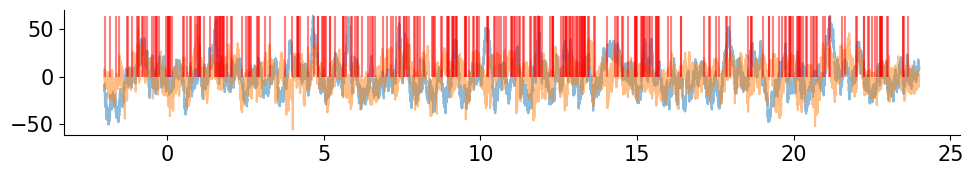

In [304]:
plt.figure(figsize=(10,2))
plt.plot(time, lfp.T, alpha=0.5)
plt.vlines(spike_times, 0, lfp.max(), "r", alpha=0.5)
plt.show()

### Function to crop a prespike window

In [305]:
def crop_prespike_window(lfp, t_spike, time, window_size, channel):
    in_window = (time < t_spike) & (time > t_spike - window_size)
    return lfp[channel, in_window]

def to_sample_idx(t_spike, time):
    return np.argmin((t_spike - time)**2)

def crop_prespike_window(lfp, idx_spike, window_size, channel):
    return lfp[channel, idx_spike-window_size:idx_spike]

### Plot spike triggered LFP

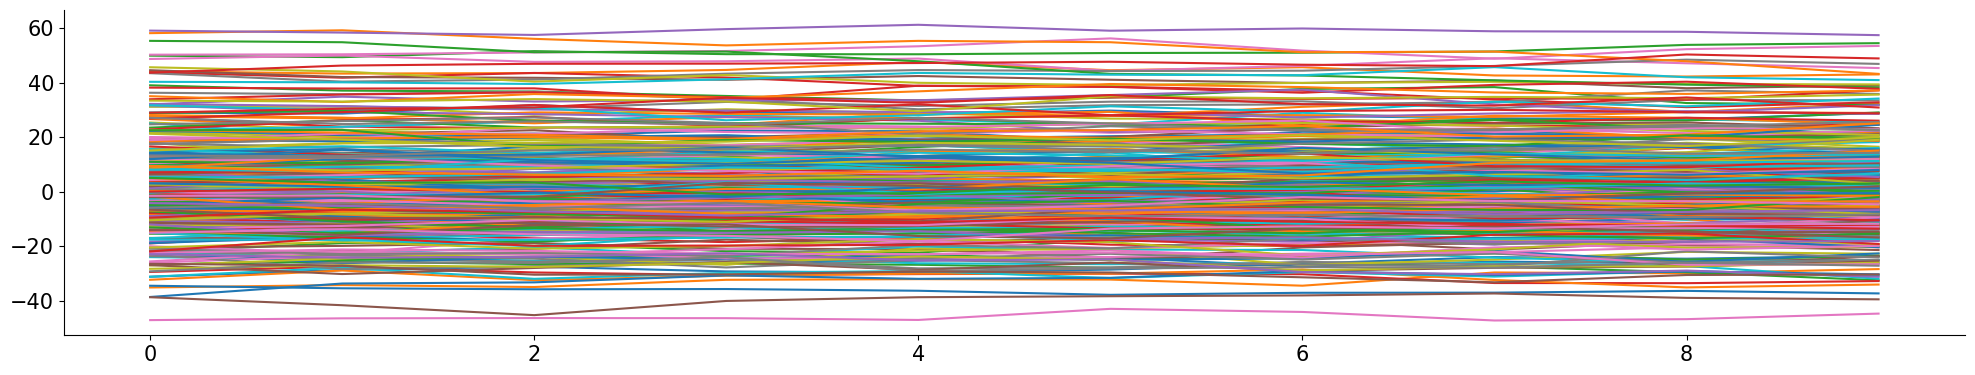

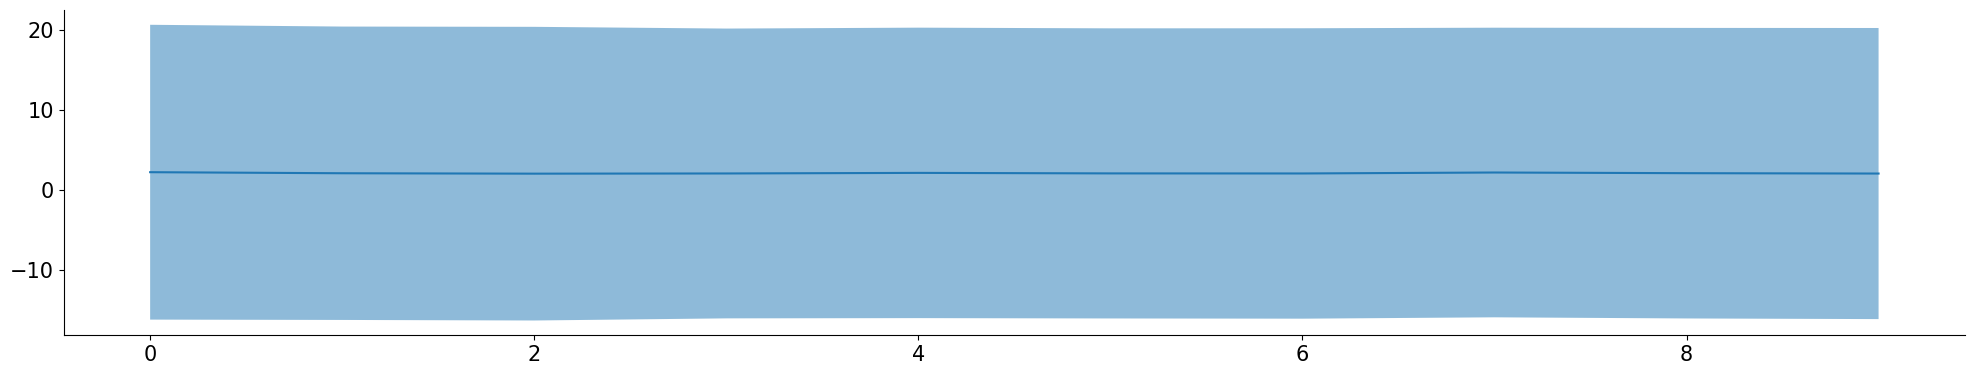

In [307]:
window_size = 10
channel_idx = 0

prespike_lfps = []
for t_spike in spike_times:
    idx_spike = to_sample_idx(t_spike, time)
    prespike_lfps.append(crop_prespike_window(lfp, idx_spike, window_size, channel_idx))
prespike_lfps = np.stack(prespike_lfps)

plt.plot(prespike_lfps.T)
plt.show()

st_avg_lfp = prespike_lfps.mean(0)
st_var_lfp = prespike_lfps.std(0)

plt.plot(st_avg_lfp.T)
plt.fill_between(range(window_size), st_avg_lfp+st_var_lfp, st_avg_lfp-st_var_lfp, alpha=0.5)
plt.show()

### Extract data for a unit

In [285]:
unit = 1
spike_times_id = f"Spike_Times_Unit_{unit}_"

spike_times_ds = []
lfp_ds = []
for f_mat in files_mat:
    session = f_mat.stem
    with h5py.File(f_mat, "r") as f:
        for key in f["data"][session]["data_arrays"].keys():
            # only extract spike times for a relevant unit
            if spike_times_id in key:
                # provide a key matching the trial for a relevant unit
                trial_id = key.split("_")[-1]
                trial_key = f"iEEG_Data_Trial_{trial_id}"
                # extract spike times and lfp of the current trial
                spike_times = torch.tensor(np.array(f["data"][session]["data_arrays"][key]["data"]))
                lfp = torch.tensor(np.array(f["data"][session]["data_arrays"][trial_key]["data"]))
                # collect spike times and lfps
                spike_times_ds.append(spike_times)
                lfp_ds.append(lfp)
            

In [298]:
X = defaultdict(list)
for spike_times, lfp in zip(spike_times_ds, lfp_ds):
    # handle single channels
    if lfp.dim() < 2:
        lfp = lfp.unsqueeze(0)
    for t_spike in spike_times:
        idx_spike = to_sample_idx(t_spike, time)
        X["time"].append(idx_spike.item())
        X["prespike_lfp"].append(crop_prespike_window(lfp, idx_spike, window_size, channel_idx))
    

defaultdict(list,
            {'time': [0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              1549,
              2373,
              2529,
              2871,
              3199,
              3503,
              4477,
              4877,
              4981,
              5611,
              6283,
              6327,
              7617,
              7794,
              8889,
              9582,
              9920,
              10650,
              10830,
              11088,
              11323,
              11502,
              11820,
              11872,
              11991,
              12034,
              12349,
              12425,
              13697,
              14000,
              14391,
              15208,
              15385,
              15404,
              15507,
              15683,
              16495,
              16656,
              16835,
              16865,
              1